In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

# Plot configurations
% matplotlib inline

In [2]:
us_state_abbrev = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO',
                   'Connecticut': 'CT','Delaware': 'DE','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID',
                   'Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
                   'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
                   'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
                   'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC',
                   'North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA',
                   'Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX',
                   'Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV',
                   'Wisconsin': 'WI','Wyoming': 'WY'}

# Load and Pre-process Data

In [3]:
warehouses = pd.read_csv("Data/CSV/amazon_labelled_locations.csv")
moodys = pd.read_csv("Data/CSV/MoodysData-ACS.csv")

# Drop some columns we don't need, drop rows with that we know we don't have data for
moodys = moodys.drop("Unnamed: 0", axis=1)
moodys = moodys.drop("Code", axis=1)
moodys = moodys.drop("Include in Amazon Dataset", axis=1)
moodys = moodys.drop("Current Senior Most Rating*", axis=1)
moodys = moodys.drop("Tax Backed Rating Description", axis=1)
moodys = moodys.drop("No. Persons/Household (ACS Data)", axis=1)
cols = list(moodys.columns)
cols[0] = "County"
cols[1] = "Year"
moodys.columns = cols
moodys = moodys[moodys.Year.between(2012, 2015, inclusive=True)].reset_index(drop=True)
moodys = moodys[moodys.County != "Median"]
moodys = moodys.apply(pd.to_numeric, errors="ignore", downcast="float")
moodys.County = map(lambda x: x[0], moodys.County.str.split(','))

metrics = cols[3:]
for metric in metrics:
    if metric not in ["No. Persons/Household (ACS Data)","Median Age (ACS Data)","% Below Poverty Level (ACS Data)"]:
        moodys[metric] = pd.to_numeric(moodys[metric].str.replace(",",""))
        
moodys = moodys.dropna(how='any', subset=metrics)

warehouses["State"] = map(lambda x: us_state_abbrev[x], warehouses["State"])
eligible_warehouses = warehouses[np.logical_or(warehouses.Year == 2013, warehouses.Year == 2014)]
counties_with_warehouses_13_14 = eligible_warehouses[["State", "County"]].drop_duplicates().reset_index(drop=True)
counties_with_warehouses_pre2015 = warehouses[warehouses.Year < 2015][["State", "County"]].drop_duplicates().reset_index(drop=True)

In [4]:
metrics

['Population (ACS Data)',
 'Per Capita Income  (ACS Data)',
 'Median Family Income  (ACS Data)',
 'Median Home Value (ACS Data)',
 'Median Gross Rent (ACS Data)',
 'Occupied Housing Units (ACS Data)',
 'Seasonal Homes (ACS Data)',
 'Median Age (ACS Data)',
 '% Below Poverty Level (ACS Data)']

In [5]:
moodys_2012 = moodys[moodys.Year == 2012].drop("Year", axis=1).reset_index(drop=True)
moodys_2013 = moodys[moodys.Year == 2013].drop("Year", axis=1).reset_index(drop=True)
moodys_2014 = moodys[moodys.Year == 2014].drop("Year", axis=1).reset_index(drop=True)
moodys_2015 = moodys[moodys.Year == 2015].drop("Year", axis=1).reset_index(drop=True)

# Amazon Counties vs. All Counties

In [6]:
joined_all_counties = moodys_2012.merge(moodys_2015, on=["County", "State"], suffixes=('_2012', '_2015'))
joined_amazon_counties = joined_all_counties.merge(counties_with_warehouses_13_14, on=["County", "State"])

In [7]:
def plot_histograms(df1, df2, bins1, bins2, title, cutoff=.15, all_counties=True):
    f, ax = plt.subplots(1,2, figsize=(14,6))
    df1[df1.between(-cutoff, cutoff)].hist(bins=bins1, ax=ax[0])
    df2[df2.between(-cutoff, cutoff)].hist(bins=bins2, ax=ax[1])
    f.suptitle(title, fontsize=16, fontweight="bold")
    if all_counties:
        ax[0].set_title("All Counties")
    else:
        ax[0].set_title('Match Counties')
    ax[1].set_title("Counties with a warehouse built in 2013 or 2014")
    ax[0].xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    ax[1].xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    
    print("KS-Test P-Value: " + str(stats.ks_2samp(df1, df2)[1]))
    print("Means:" + str(np.mean(df1)) + " (Control), " + str(np.mean(df2)) + " (Amazon)")

KS-Test P-Value: 4.69008692673e-13
Means:0.0165588289986 (Control), 0.0422622443545 (Amazon)


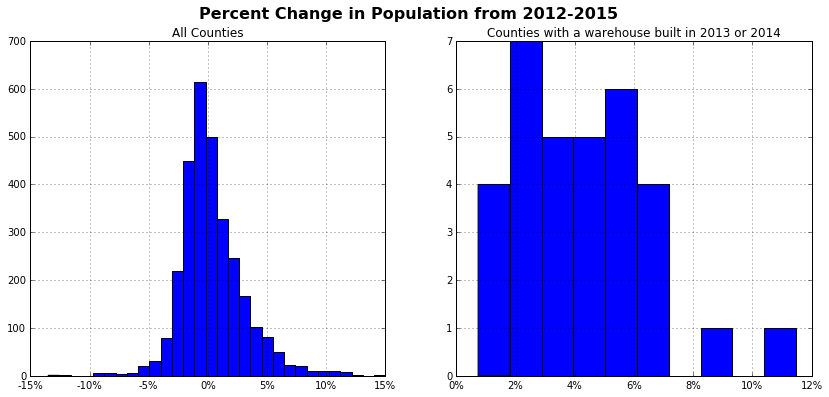

In [8]:
pop_percent_change = ((joined_all_counties["Population (ACS Data)_2015"] -
 joined_all_counties["Population (ACS Data)_2012"]) / 
 joined_all_counties["Population (ACS Data)_2012"])

pop_percent_change_amazon = ((joined_amazon_counties["Population (ACS Data)_2015"] -
 joined_amazon_counties["Population (ACS Data)_2012"]) /
 joined_amazon_counties["Population (ACS Data)_2012"])

plot_histograms(pop_percent_change, pop_percent_change_amazon, 30, 10, "Percent Change in Population from 2012-2015")

KS-Test P-Value: 0.000963409268772
Means:0.0432995681429 (Control), 0.0225073592427 (Amazon)


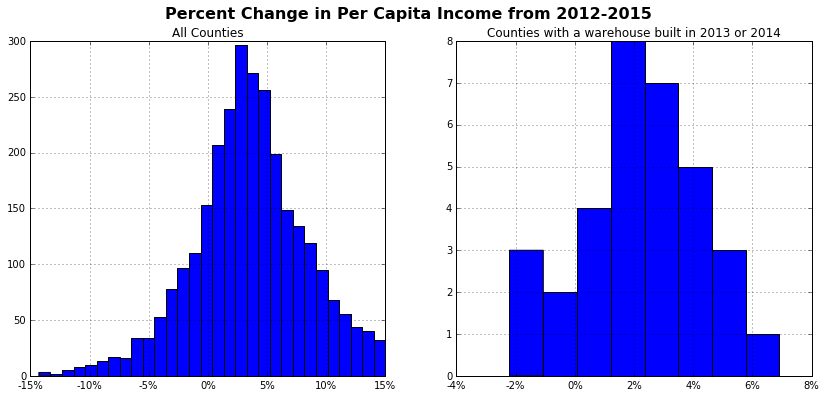

In [9]:
percap_income_change = ((joined_all_counties["Per Capita Income  (ACS Data)_2015"] -
joined_all_counties["Per Capita Income  (ACS Data)_2012"]) /
joined_all_counties["Per Capita Income  (ACS Data)_2012"])

percap_income_change_amazon = ((joined_amazon_counties["Per Capita Income  (ACS Data)_2015"] -
joined_amazon_counties["Per Capita Income  (ACS Data)_2012"]) /
joined_amazon_counties["Per Capita Income  (ACS Data)_2012"])

plot_histograms(percap_income_change, percap_income_change_amazon, 30,8,
                "Percent Change in Per Capita Income from 2012-2015")

KS-Test P-Value: 0.0168945582654
Means:0.0316316807475 (Control), -0.00887880759391 (Amazon)


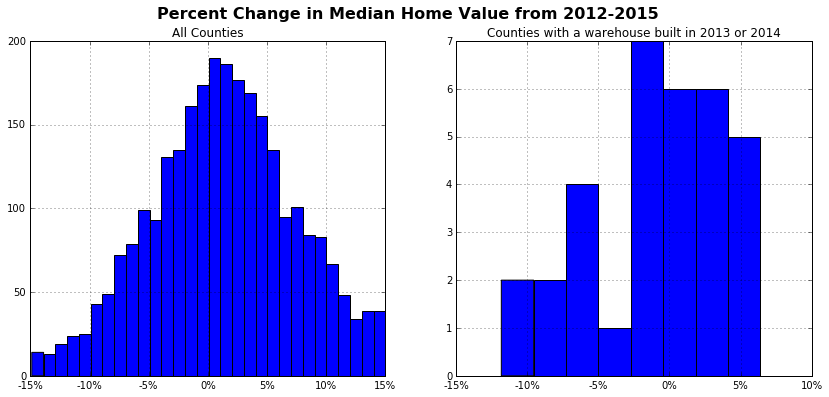

In [10]:
home_value_change = ((joined_all_counties["Median Home Value (ACS Data)_2015"] -
 joined_all_counties["Median Home Value (ACS Data)_2012"]) /
 joined_all_counties["Median Home Value (ACS Data)_2012"])

home_value_change_amazon = ((joined_amazon_counties["Median Home Value (ACS Data)_2015"] -
 joined_amazon_counties["Median Home Value (ACS Data)_2012"]) /
 joined_amazon_counties["Median Home Value (ACS Data)_2012"])

plot_histograms(home_value_change, home_value_change_amazon, 30, 8, "Percent Change in Median Home Value from 2012-2015")

KS-Test P-Value: 0.00583720525506
Means:0.0525963184765 (Control), 0.0401821871907 (Amazon)


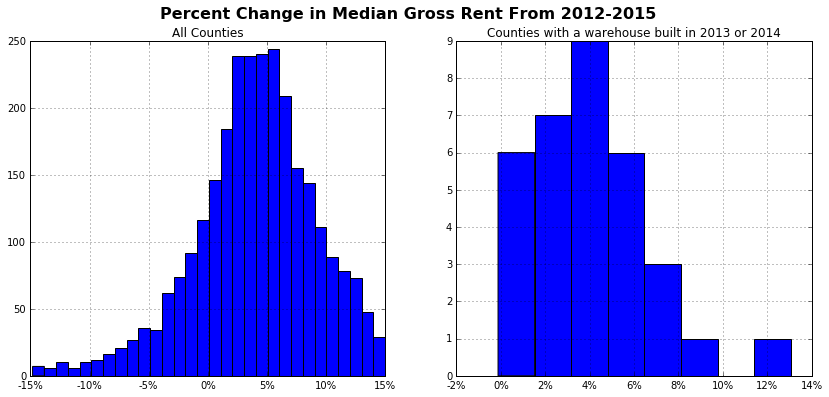

In [11]:
rent_percent_change = ((joined_all_counties["Median Gross Rent (ACS Data)_2015"] -
 joined_all_counties["Median Gross Rent (ACS Data)_2012"]) /
 joined_all_counties["Median Gross Rent (ACS Data)_2012"])

rent_percent_change_amazon = ((joined_amazon_counties["Median Gross Rent (ACS Data)_2015"] -
 joined_amazon_counties["Median Gross Rent (ACS Data)_2012"]) /
 joined_amazon_counties["Median Gross Rent (ACS Data)_2012"])

plot_histograms(rent_percent_change, rent_percent_change_amazon, 30, 8, "Percent Change in Median Gross Rent From 2012-2015")

# Amazon Counties vs. Similar Non-Amazon Counties

In [12]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

scaled_joined_all_counties = joined_all_counties.dropna().reset_index(drop=True)
scaled_joined_all_counties.iloc[:, 2:] = scaler.fit_transform(scaled_joined_all_counties.iloc[:, 2:].copy())

counties_with_warehouses_pre2015_dummy = counties_with_warehouses_pre2015.copy()
counties_with_warehouses_pre2015_dummy["dummy"] = 0
scaled_all_counties_dummy = scaled_joined_all_counties.merge(counties_with_warehouses_pre2015_dummy, on=["State","County"], how="left")
scaled_non_amazon_counties = scaled_all_counties_dummy[scaled_all_counties_dummy.dummy.isnull()].reset_index(drop=True).drop("dummy", axis=1)

scaled_amazon_counties = scaled_joined_all_counties.merge(counties_with_warehouses_13_14, on=["State","County"])

In [13]:
matches = pd.DataFrame({"WH_State": scaled_amazon_counties.State, "WH_County": scaled_amazon_counties.County})
match_list = []
for _, row in scaled_amazon_counties.iterrows():
    distance_indices = np.argsort(np.linalg.norm(scaled_non_amazon_counties.iloc[:,2:].subtract(row.iloc[2:]).astype(float), axis=1))
    found_valid_match = False
    ind = 0
    while not found_valid_match:
        match_county, match_state = scaled_non_amazon_counties.iloc[distance_indices[ind]][['County','State']]
        match_tuple = (match_county, match_state)
        
        if not match_tuple in match_list:
            match_list.append(match_tuple)
            found_valid_match = True
        
        ind += 1

matches['Non_WH_County'] = [x[0] for x in match_list]
matches['Non_WH_State'] = [x[1] for x in match_list]

In [14]:
matches

,WH_County,WH_State,Non_WH_County,Non_WH_State
0,Alameda County,CA,Contra Costa County,CA
1,Boone County,IN,Platte County,MO
2,Boone County,KY,Grundy County,IL
3,Bullitt County,KY,Christian County,MO
4,Cabarrus County,NC,York County,SC
5,Cumberland County,PA,Medina County,OH
6,Dallas County,TX,Bexar County,TX
7,Dauphin County,PA,Berks County,PA
8,Fulton County,GA,Travis County,TX
9,Gloucester County,NJ,McHenry County,IL


In [15]:
joined_match_counties = joined_all_counties.merge(matches, left_on=['State', 'County'], right_on=['Non_WH_State', 'Non_WH_County'])

KS-Test P-Value: 0.402693284904
Means:0.0352522380699 (Control), 0.0422622443545 (Amazon)


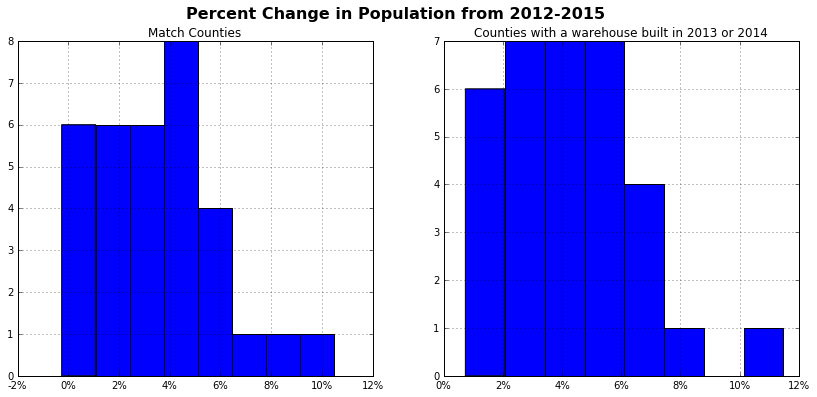

In [16]:
match_pop_percent_change = ((joined_match_counties["Population (ACS Data)_2015"] -
 joined_match_counties["Population (ACS Data)_2012"]) / 
 joined_match_counties["Population (ACS Data)_2012"])

pop_percent_change_amazon = ((joined_amazon_counties["Population (ACS Data)_2015"] -
 joined_amazon_counties["Population (ACS Data)_2012"]) /
 joined_amazon_counties["Population (ACS Data)_2012"])

plot_histograms(match_pop_percent_change, pop_percent_change_amazon, 8,8, "Percent Change in Population from 2012-2015", all_counties=False)

KS-Test P-Value: 0.957047951171
Means:0.0253554397332 (Control), 0.0225073592427 (Amazon)


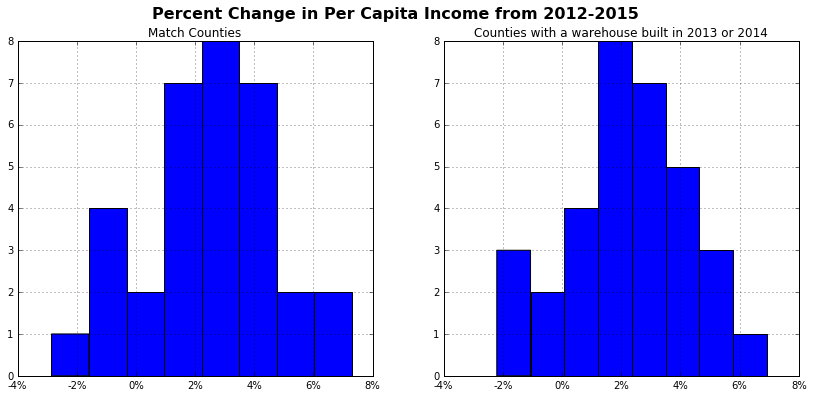

In [17]:
match_percap_income_change = ((joined_match_counties["Per Capita Income  (ACS Data)_2015"] -
joined_match_counties["Per Capita Income  (ACS Data)_2012"]) /
joined_match_counties["Per Capita Income  (ACS Data)_2012"])

percap_income_change_amazon = ((joined_amazon_counties["Per Capita Income  (ACS Data)_2015"] -
joined_amazon_counties["Per Capita Income  (ACS Data)_2012"]) /
joined_amazon_counties["Per Capita Income  (ACS Data)_2012"])

plot_histograms(match_percap_income_change, percap_income_change_amazon, 8,8,
                "Percent Change in Per Capita Income from 2012-2015", cutoff=.2, all_counties=False)

KS-Test P-Value: 0.0772558505706
Means:-0.0278266474977 (Control), -0.00887880759391 (Amazon)


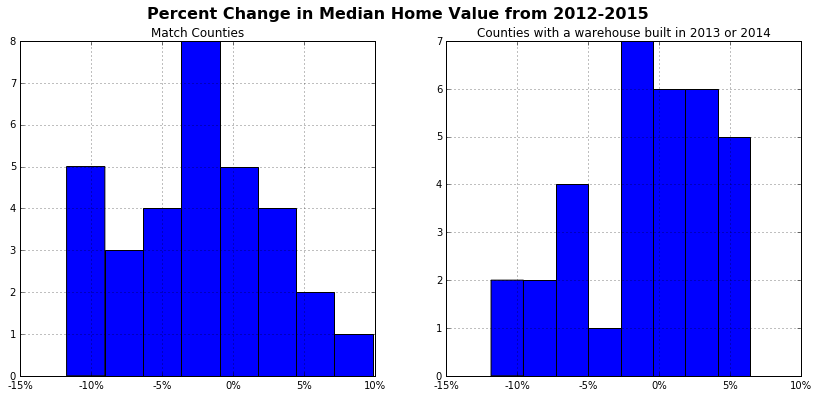

In [18]:
match_home_value_change = ((joined_match_counties["Median Home Value (ACS Data)_2015"] -
 joined_match_counties["Median Home Value (ACS Data)_2012"]) /
 joined_match_counties["Median Home Value (ACS Data)_2012"])

home_value_change_amazon = ((joined_amazon_counties["Median Home Value (ACS Data)_2015"] -
 joined_amazon_counties["Median Home Value (ACS Data)_2012"]) /
 joined_amazon_counties["Median Home Value (ACS Data)_2012"])

plot_histograms(match_home_value_change, home_value_change_amazon, 8, 8, "Percent Change in Median Home Value from 2012-2015", all_counties=False)

KS-Test P-Value: 0.248783362405
Means:0.0520965883026 (Control), 0.0401821871907 (Amazon)


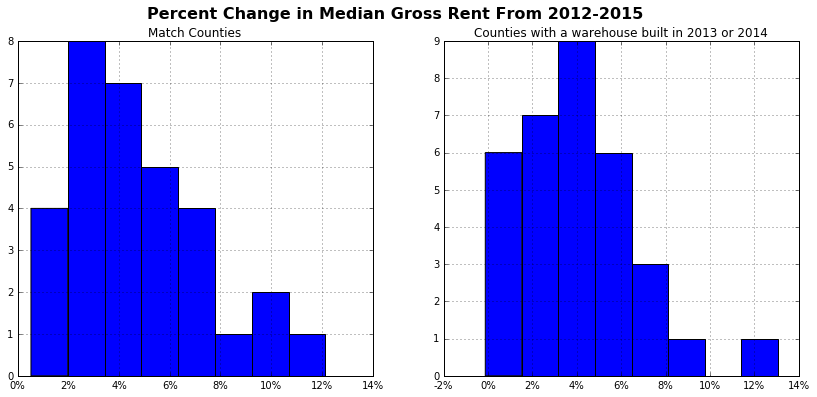

In [19]:
match_rent_percent_change = ((joined_match_counties["Median Gross Rent (ACS Data)_2015"] -
 joined_match_counties["Median Gross Rent (ACS Data)_2012"]) /
 joined_match_counties["Median Gross Rent (ACS Data)_2012"])

rent_percent_change_amazon = ((joined_amazon_counties["Median Gross Rent (ACS Data)_2015"] -
 joined_amazon_counties["Median Gross Rent (ACS Data)_2012"]) /
 joined_amazon_counties["Median Gross Rent (ACS Data)_2012"])

plot_histograms(match_rent_percent_change, rent_percent_change_amazon, 8, 8, "Percent Change in Median Gross Rent From 2012-2015", all_counties=False)

In [20]:
match_warehouses = matches.merge(warehouses, left_on=['Non_WH_State', 'Non_WH_County'], right_on=['State','County'])[['State','County','Year']]

In [21]:
gb = match_warehouses.groupby(by=['State','County']).count()
print(gb.shape[0], matches.shape[0])
print(gb)

(10, 33)
                           Year
State County                   
CA    Contra Costa County     1
      Orange County           5
      San Mateo County        1
FL    Duval County            4
IL    Cook County             3
MA    Middlesex County        2
NJ    Bergen County           2
OH    Franklin County         2
TX    Bexar County            2
      Travis County           2


In [22]:
match_warehouses.Year.value_counts()

2015.0    11
2017.0     6
2016.0     6
2018.0     1
Name: Year, dtype: int64

# Propensity Score Matching

In [23]:
from causality.estimation.parametric import PropensityScoreMatching

matcher = PropensityScoreMatching()

joined_all_counties_dummy = scaled_joined_all_counties.merge(counties_with_warehouses_pre2015_dummy, on=["State","County"], how="left")
joined_non_amazon_counties = joined_all_counties_dummy[joined_all_counties_dummy.dummy.isnull()].reset_index(drop=True).drop("dummy", axis=1)

treatment_indicator = [0 if ind < len(joined_non_amazon_counties) else 1 
                       for ind in range(len(joined_non_amazon_counties) + len(joined_amazon_counties))]

X = pd.concat([joined_non_amazon_counties, scaled_amazon_counties]).reset_index(drop=True)
X['treatment'] = treatment_indicator

Optimization terminated successfully.
         Current function value: 0.038147
         Iterations 10
Population (ACS Data) {'propensity score': -0.0034789371341590043}
Per Capita Income  (ACS Data)_2012         0.812979
Median Age (ACS Data)_2012                -6.359897
% Below Poverty Level (ACS Data)_2012     -4.395841
Occupied Housing Units (ACS Data)_2012    15.898088
Median Family Income  (ACS Data)_2012      0.868185
Median Home Value (ACS Data)_2012         -4.284628
Seasonal Homes (ACS Data)_2012             1.269863
Median Gross Rent (ACS Data)_2012          4.934813
intercept                                 -3.121703
dtype: float64
KS-Test P-Value: 0.402693284904
Means:0.0406162243375 (Control), 0.0422622443545 (Amazon)



Optimization terminated successfully.
         Current function value: 0.037928
         Iterations 11
Per Capita Income  (ACS Data) {'propensity score': -0.0035138823534292796}
Population (ACS Data)_2012                34.867840
Median Age (ACS Data)_20

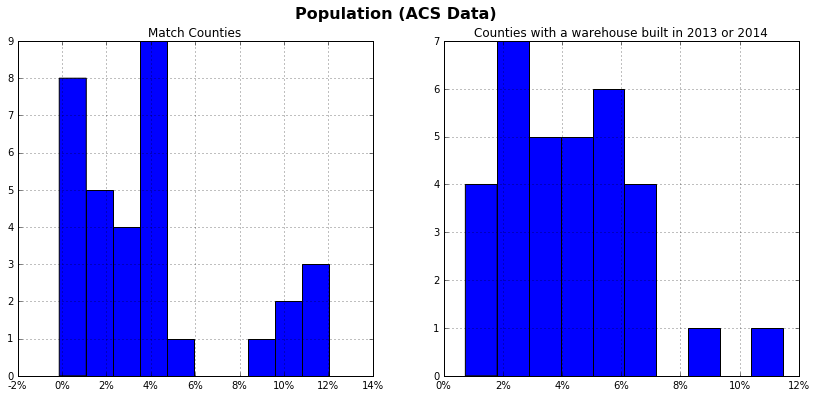

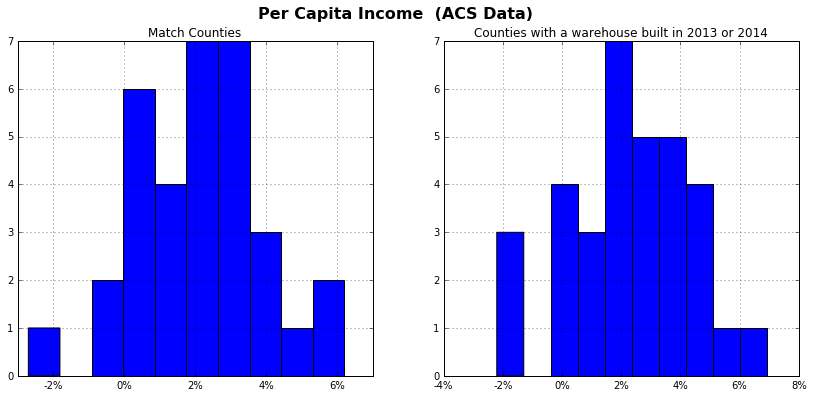

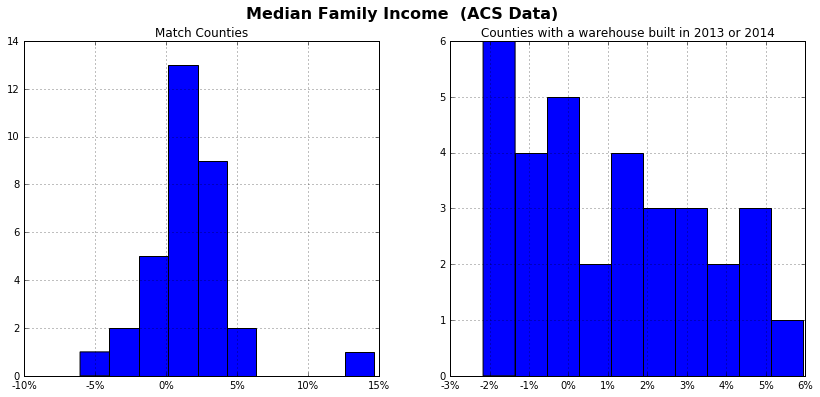

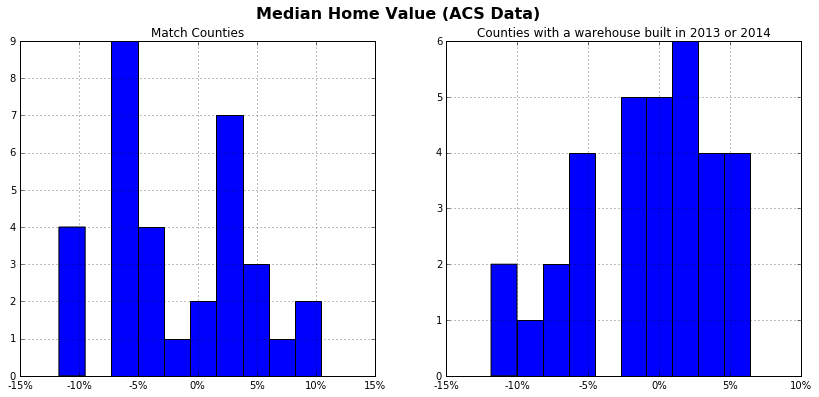

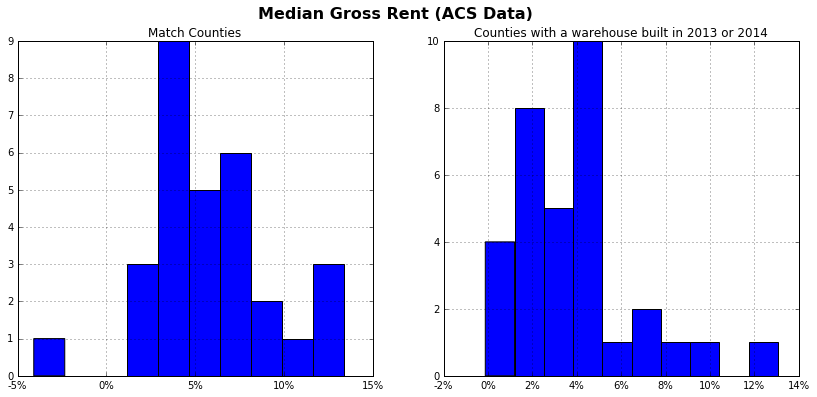

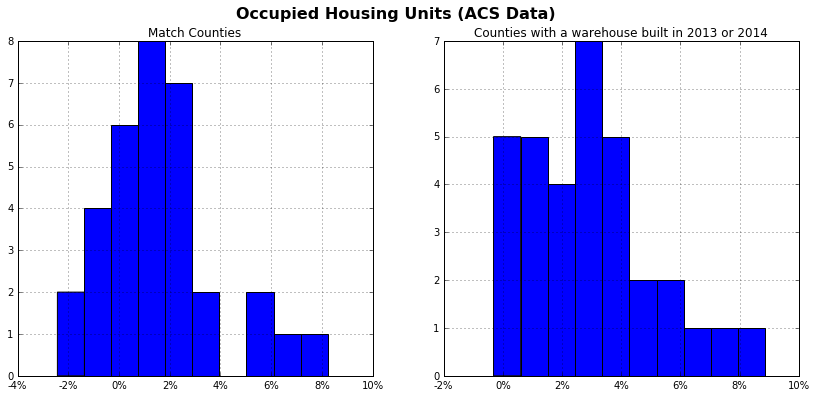

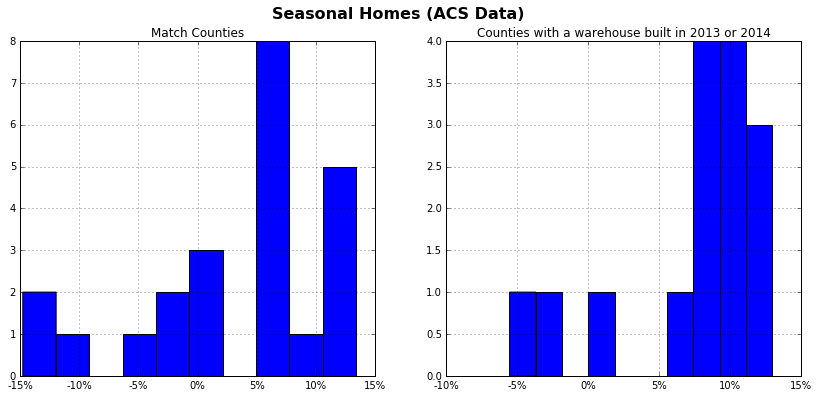

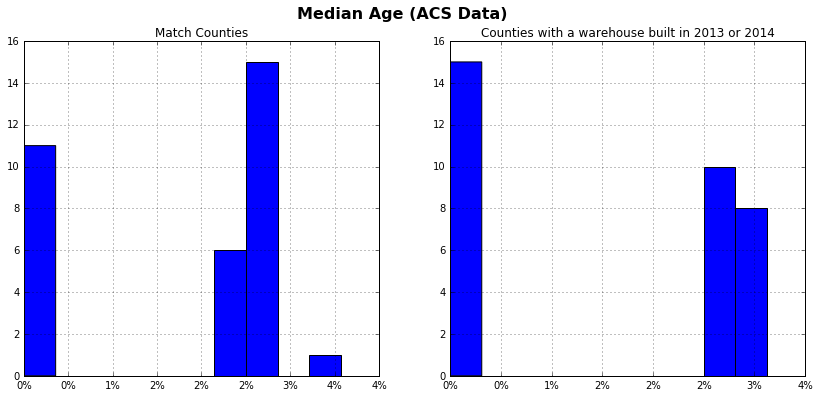

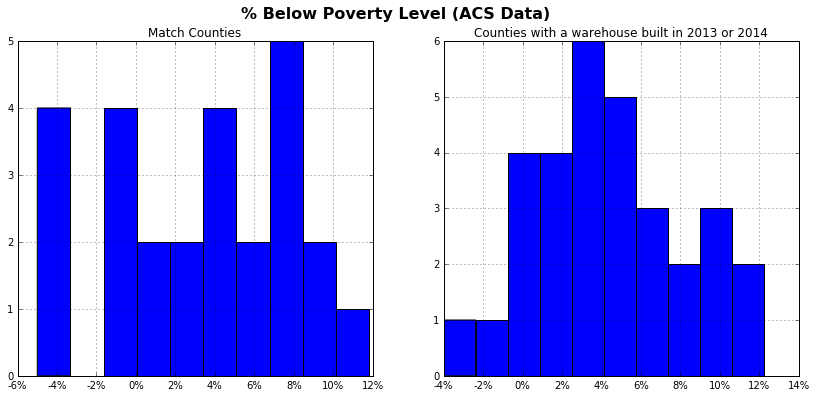

In [32]:
for left_out_metric in metrics:
    confounder_types_pop = {m: 'c' for m in [metric + "_2012" for metric in metrics if metric != left_out_metric]}
    X = matcher.score(X, assignment='treatment', confounder_types=confounder_types_pop, store_model_fit=True);
    treated, control = matcher.match(X, assignment='treatment', n_neighbors=1)

    joined_treated_counties = joined_all_counties.merge(treated[["County", 'State']])
    joined_control_counties = joined_all_counties.merge(control[["County", 'State']])

    print left_out_metric, matcher.assess_balance(treated.append(control), 'treatment', {'propensity score': 'c'})
    print matcher.propensity_score_model.params
    
    percent_change_control = ((joined_control_counties[left_out_metric + "_2015"] -
     joined_control_counties[left_out_metric + "_2012"]) /
     joined_control_counties[left_out_metric + "_2012"])

    percent_change_treated = ((joined_treated_counties[left_out_metric + "_2015"] -
     joined_treated_counties[left_out_metric + "_2012"]) / 
     joined_treated_counties[left_out_metric + "_2012"])

    plot_histograms(percent_change_control,percent_change_treated, 10, 10, left_out_metric, all_counties=False)
    print '\n\n'

In [31]:
print matcher.propensity_score_model.params

Population (ACS Data)_2012                50.552798
Per Capita Income  (ACS Data)_2012         3.701021
Median Age (ACS Data)_2012                -4.941226
Occupied Housing Units (ACS Data)_2012   -31.044356
Median Family Income  (ACS Data)_2012      1.872062
Median Home Value (ACS Data)_2012         -6.426081
Seasonal Homes (ACS Data)_2012             0.782016
Median Gross Rent (ACS Data)_2012          4.955653
intercept                                 -5.796946
dtype: float64
